Tutorial para uso da base de dados 3w:

In [1]:
import sys
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

sys.path.append('3W')
sys.path.append('BibMon')


Leitura dos arquivos do caso normal e do caso da primeira falta:

In [2]:
def load_data(event):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event))
    
    # Inicializar a lista de arquivos
    files = []
    
    if os.path.exists(PATH):
        files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if files:  # Verifica se a lista de arquivos não está vazia
        for file in files:
            file_path = os.path.join(PATH, file)
            try:
                if file.endswith('.csv'):
                    # Tentar ler o arquivo CSV com a codificação padrão
                    dfs[file[:-4]] = pd.read_csv(file_path, index_col=0, parse_dates=True).rename_axis(None)
                elif file.endswith('.parquet'):
                    # Ler o arquivo Parquet
                    dfs[file[:-8]] = pd.read_parquet(file_path)  # Remover o sufixo '.parquet'
                else:
                    print(f"Formato de arquivo desconhecido para {file}.")
            except Exception as e:
                print(f"Erro ao ler {file}: {e}")
    
        print('Data read!\nNumber of instances: ', len(dfs))
    else:
        print("Nenhum arquivo encontrado.")

    return dfs

data0 = load_data(0)
data1 = load_data(1) #Escolhemos a falta 4 por ter muitos dados do poço 2 escolhido

Data read!
Number of instances:  594
Data read!
Number of instances:  128


Análise dos dados poços:

In [3]:
def getWellDataAndPlot(well, data, color):
    archivesKeys = data.keys()

    filtered_keys = [key for key in archivesKeys if key.startswith(f"WELL-0000{well}")]
    # filteredByWellData = pd.DataFrame(data)
    filteredByWellData = pd.concat([data[key] for key in filtered_keys]) #Data filtrada para o poço
    
    filteredByWellData = filteredByWellData.apply(pd.to_numeric, errors='coerce')
    # Remover colunas que são todas NaN ou que contêm apenas zeros
    filteredByWellData = filteredByWellData.dropna(axis=1, how='all')  # Remove colunas que são todas NaN
    filteredByWellData = filteredByWellData.loc[:, (filteredByWellData != 0).any(axis=0)]  # Remove colunas que são todas 0
    
    tags = list(filteredByWellData.keys())
    tags = [item for item in tags if item != 'P-PDG']

    fig, ax = plt.subplots(len(tags), 1, figsize=(18, 10),sharex=True)
    fig.suptitle(f"Poço {well}", fontsize=16)
    
    for i, tag in enumerate(tags):
        tagData = filteredByWellData[tag].values
        # print(tagData)
        ax[i].plot(tagData, c=color, linewidth=0.8)
        ax[i].set_ylabel(tag, rotation=0, fontsize=14)
        ax[i].set_yticks([])
    
        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
    
        if i < len(tags)-1:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return filteredByWellData , tags
   


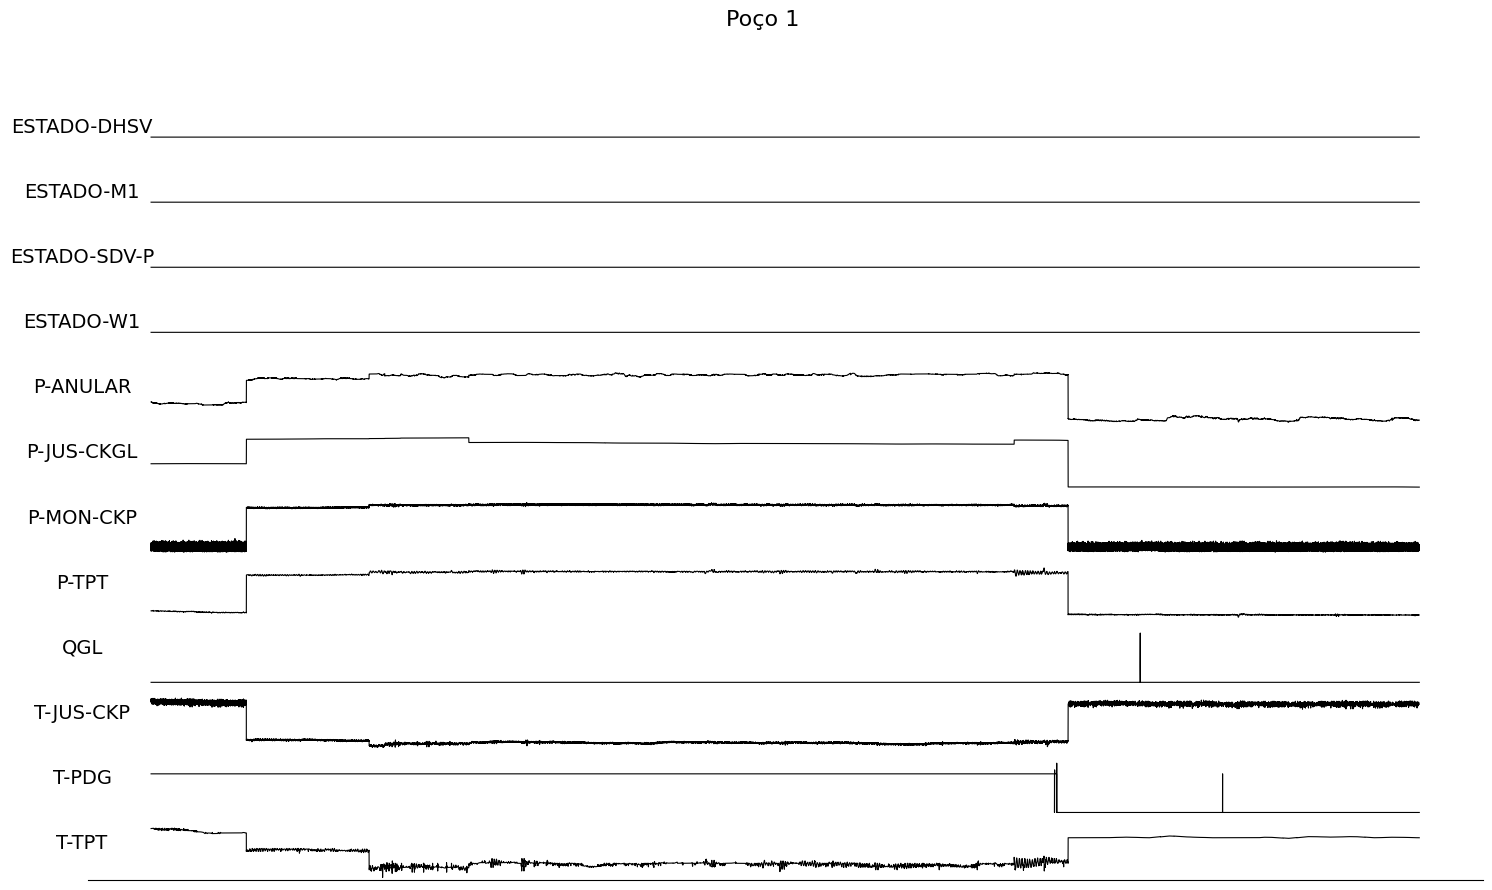

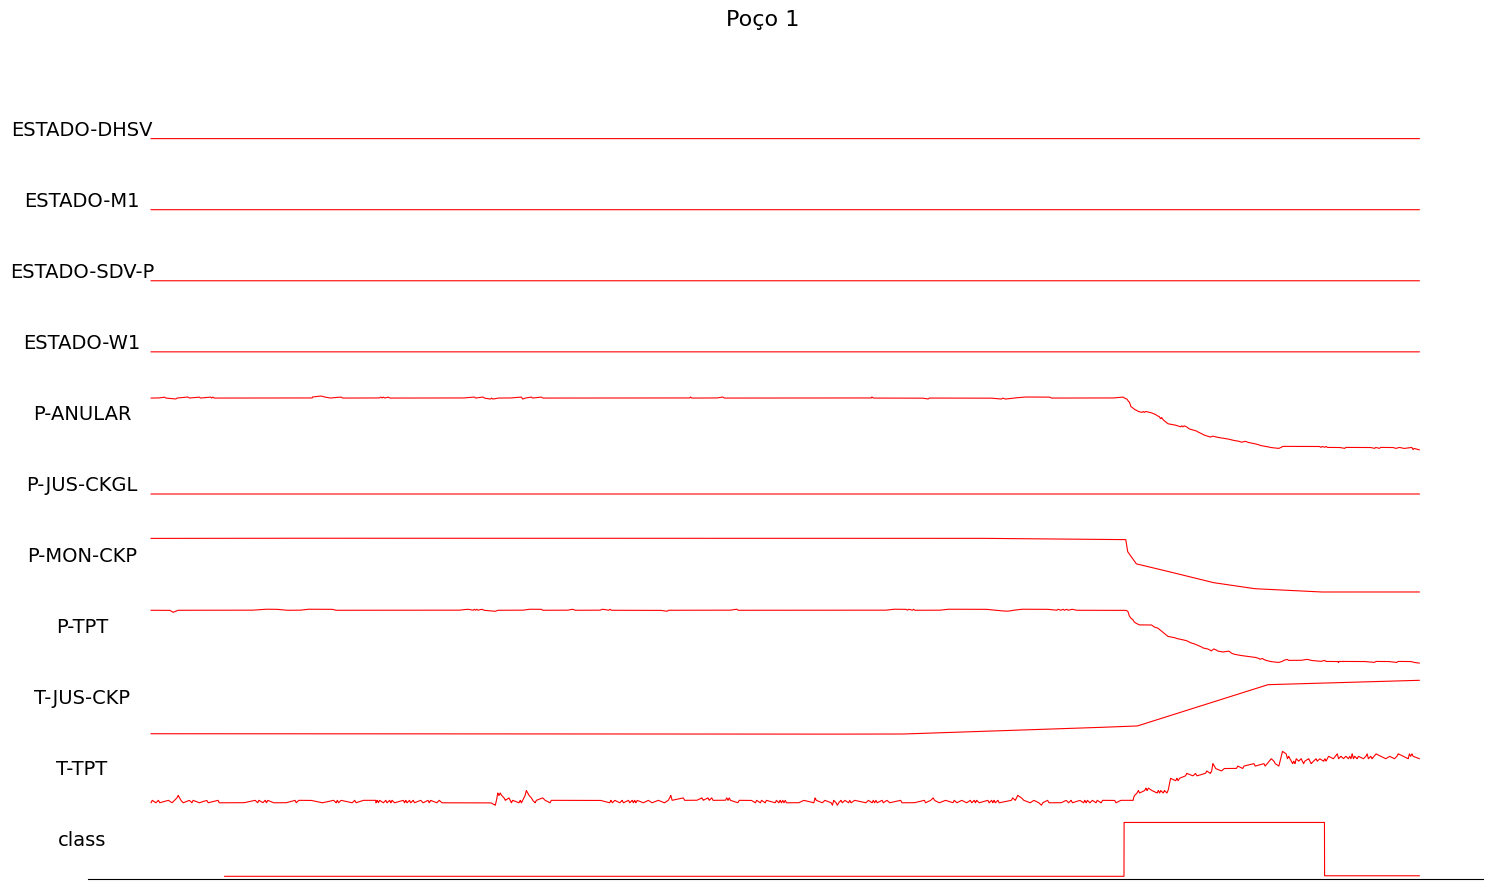

In [4]:
well = 1

datawell0, tags0 = getWellDataAndPlot(well, data0, 'k')    
datawell1, tags1 = getWellDataAndPlot(well, data1, 'r')   

# datawell0 = [datawell0[key] for key in datawell1]
# print(datawell0)

Acima temos em preto o comportamento normal de operação e em vermelho a operação da base de dados de falta
A variável class que determina quando entramos em transitório, quando ela está maior que 100, e no permanente pós falta, com class mais baixa. Em sua operação normal essa variável é 0.

In [19]:
datawell0.index = pd.to_datetime(datawell0.index)
datawell0 = datawell0.sort_index()
datawell1.index = pd.to_datetime(datawell1.index)
datawell1 = datawell1.sort_index()

print(datawell1)

                     ESTADO-DHSV  ESTADO-M1  ESTADO-SDV-P  ESTADO-W1  \
timestamp                                                              
2014-01-24 08:33:03          1.0        1.0           1.0        1.0   
2014-01-24 08:33:04          1.0        1.0           1.0        1.0   
2014-01-24 08:33:05          1.0        1.0           1.0        1.0   
2014-01-24 08:33:06          1.0        1.0           1.0        1.0   
2014-01-24 08:33:07          1.0        1.0           1.0        1.0   
...                          ...        ...           ...        ...   
2014-01-25 01:47:26          1.0        1.0           1.0        1.0   
2014-01-25 01:47:27          1.0        1.0           1.0        1.0   
2014-01-25 01:47:28          1.0        1.0           1.0        1.0   
2014-01-25 01:47:29          1.0        1.0           1.0        1.0   
2014-01-25 01:47:30          1.0        1.0           1.0        1.0   

                       P-ANULAR  P-JUS-CKGL  P-MON-CKP       P-

In [99]:
index_above_100 = datawell1[datawell1['class'] > 100].index[0]

# Agora, filtra a partir desse índice para encontrar o primeiro valor onde class < 100
first_below_100_after = datawell1.loc[index_above_100:][datawell1['class'] == 0]

fault_start = index_above_100

if not first_below_100_after.empty:
    fault_end = first_below_100_after.index[0]
else:
    fault_end = datawell1.index[-1]  # Último valor de datawell1


# Mostra os resultados
print("Primeiro índice onde class > 100:", fault_start)
print("Primeiro índice onde class < 100 após esse valor:", fault_end)


Primeiro índice onde class > 100: 2014-01-24 21:46:39
Primeiro índice onde class < 100 após esse valor: 2014-01-25 01:47:30


C:\Users\Laura\AppData\Local\Temp\ipykernel_1892\3264231004.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  first_below_100_after = datawell1.loc[index_above_100:][datawell1['class'] == 0]


Concatenação da base de dados para ter bastante tempo de treinamento:

In [100]:
import bibmon 

(X_train, X_validation, 
 X_test, Y_train, 
 Y_validation, Y_test) = bibmon.train_val_test_split(datawell1, 
                                                     start_train = '2014-01-24 08:33:03', 
                                                     end_train = '2014-01-24 15:46:39', 
                                                     end_validation = '2014-01-24 20:46:39', #Horas antes da falta
                                                     end_test = '2014-01-25 01:47:30',
                                                     tags_Y = 'T-TPT')

In [101]:
from sklearn.ensemble import RandomForestRegressor  
reg = RandomForestRegressor(n_jobs=-1, random_state=1)

model = bibmon.sklearnRegressor(reg) 

In [102]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mtr = [r2_score, mean_absolute_error]

CPU times: total: 13.7 s
Wall time: 6.36 s


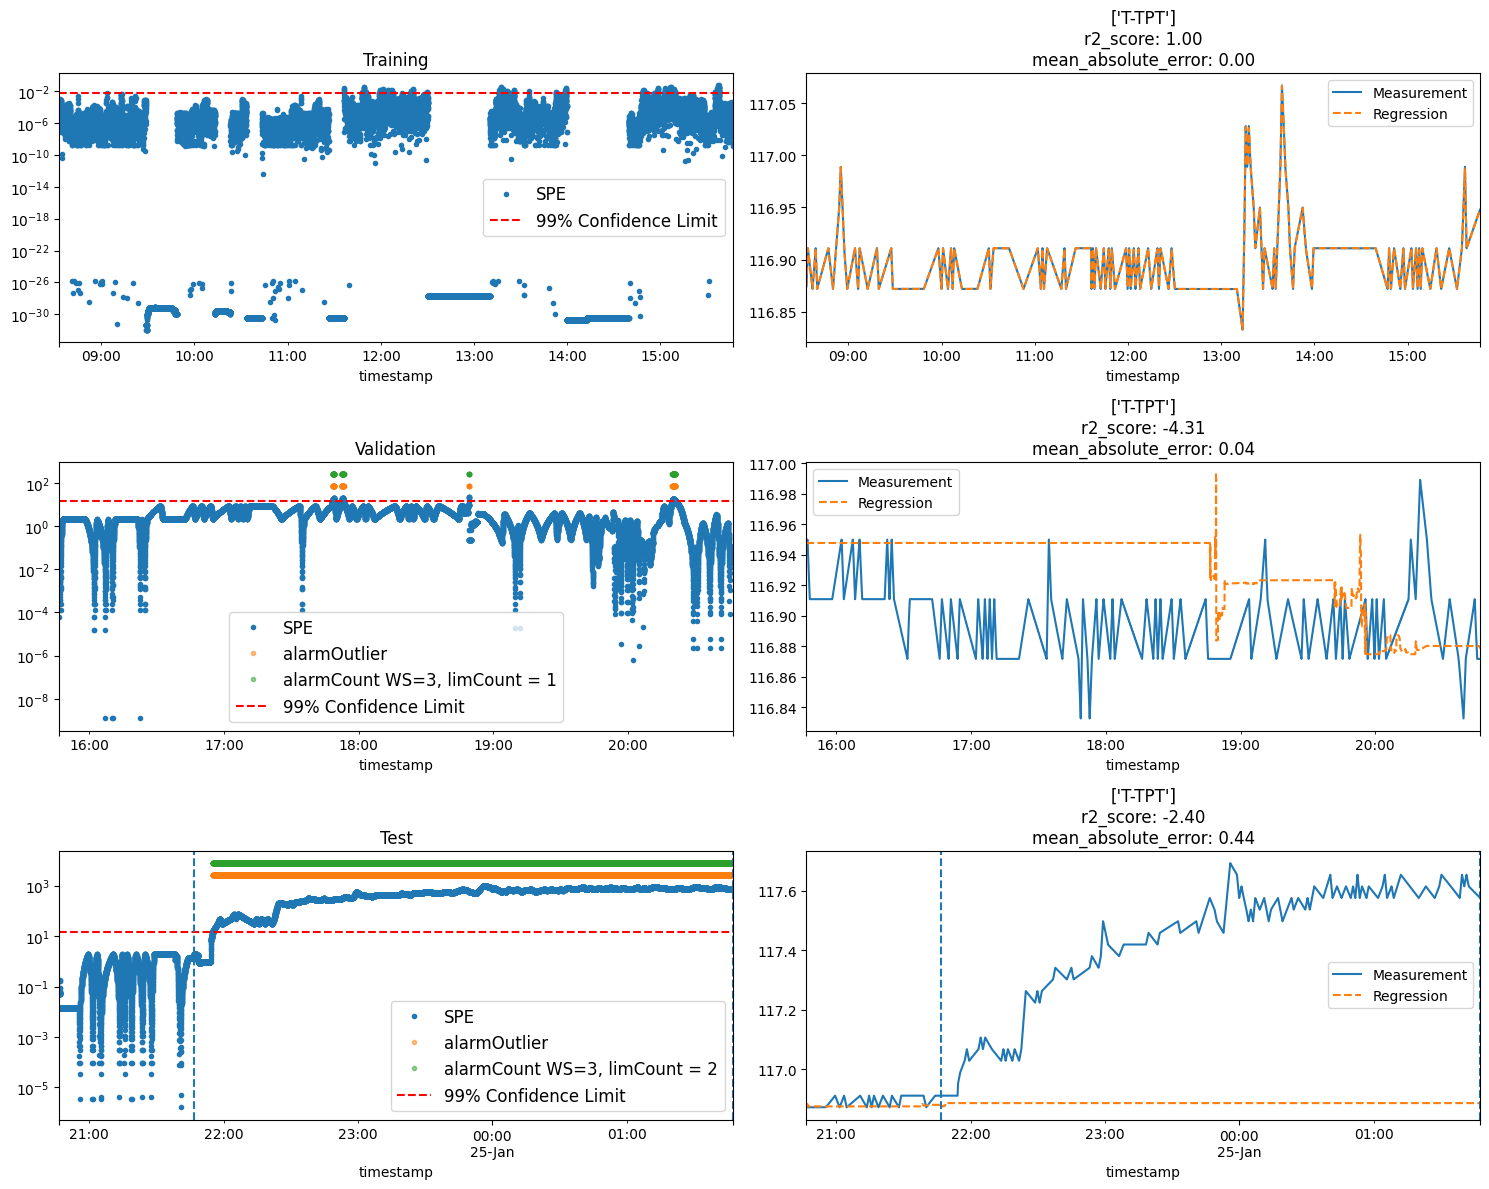

In [103]:
%%time
bibmon.complete_analysis(model, X_train, X_validation, X_test, 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = '2014-01-24 21:46:39',
                         fault_end = '2014-01-25 01:47:30')                       

Algumas variáveis, após a falta, encontram seu regime permanente estável em outro ponto de operação.
Além do overfitting, possível de ver pois o 2_score ficou longe de 1 na validação e pois diversos alarmes falsos foram ativados,
a predição acima também falha por ter período de falta muito grande comparado com o horizonte

Abaixo temos uma tentativa de encontrar uma variável muito importante que descreva a operação

T-JUS-CKP    0.612720
P-MON-CKP    0.278414
P-TPT        0.061063
P-ANULAR     0.047803
Name: Importances, dtype: float64

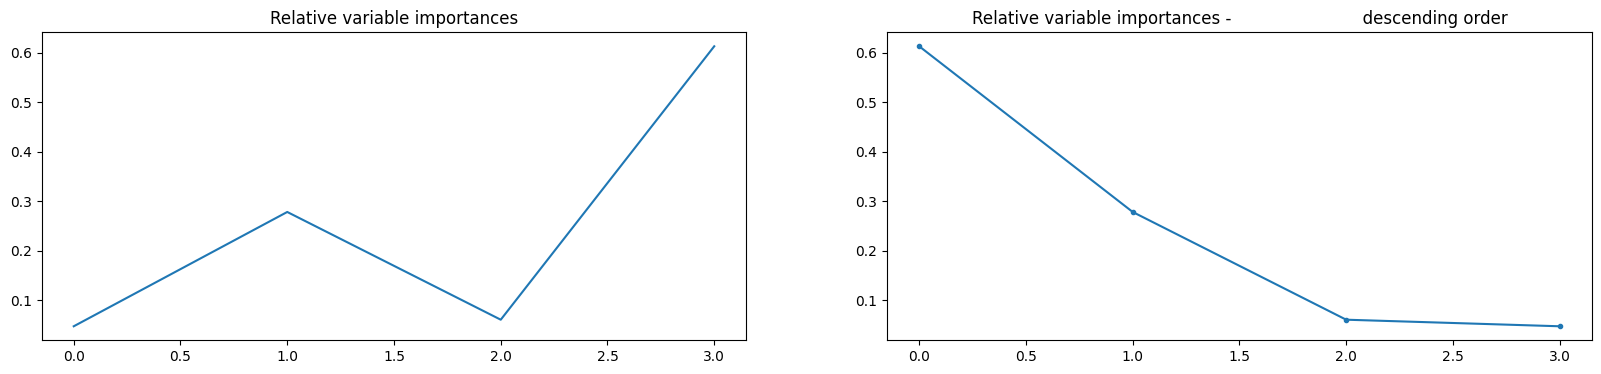

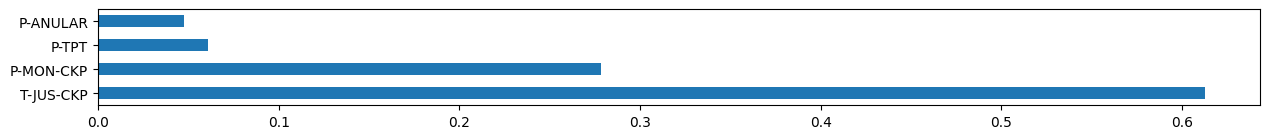

In [104]:
model.plot_importances(n=5)

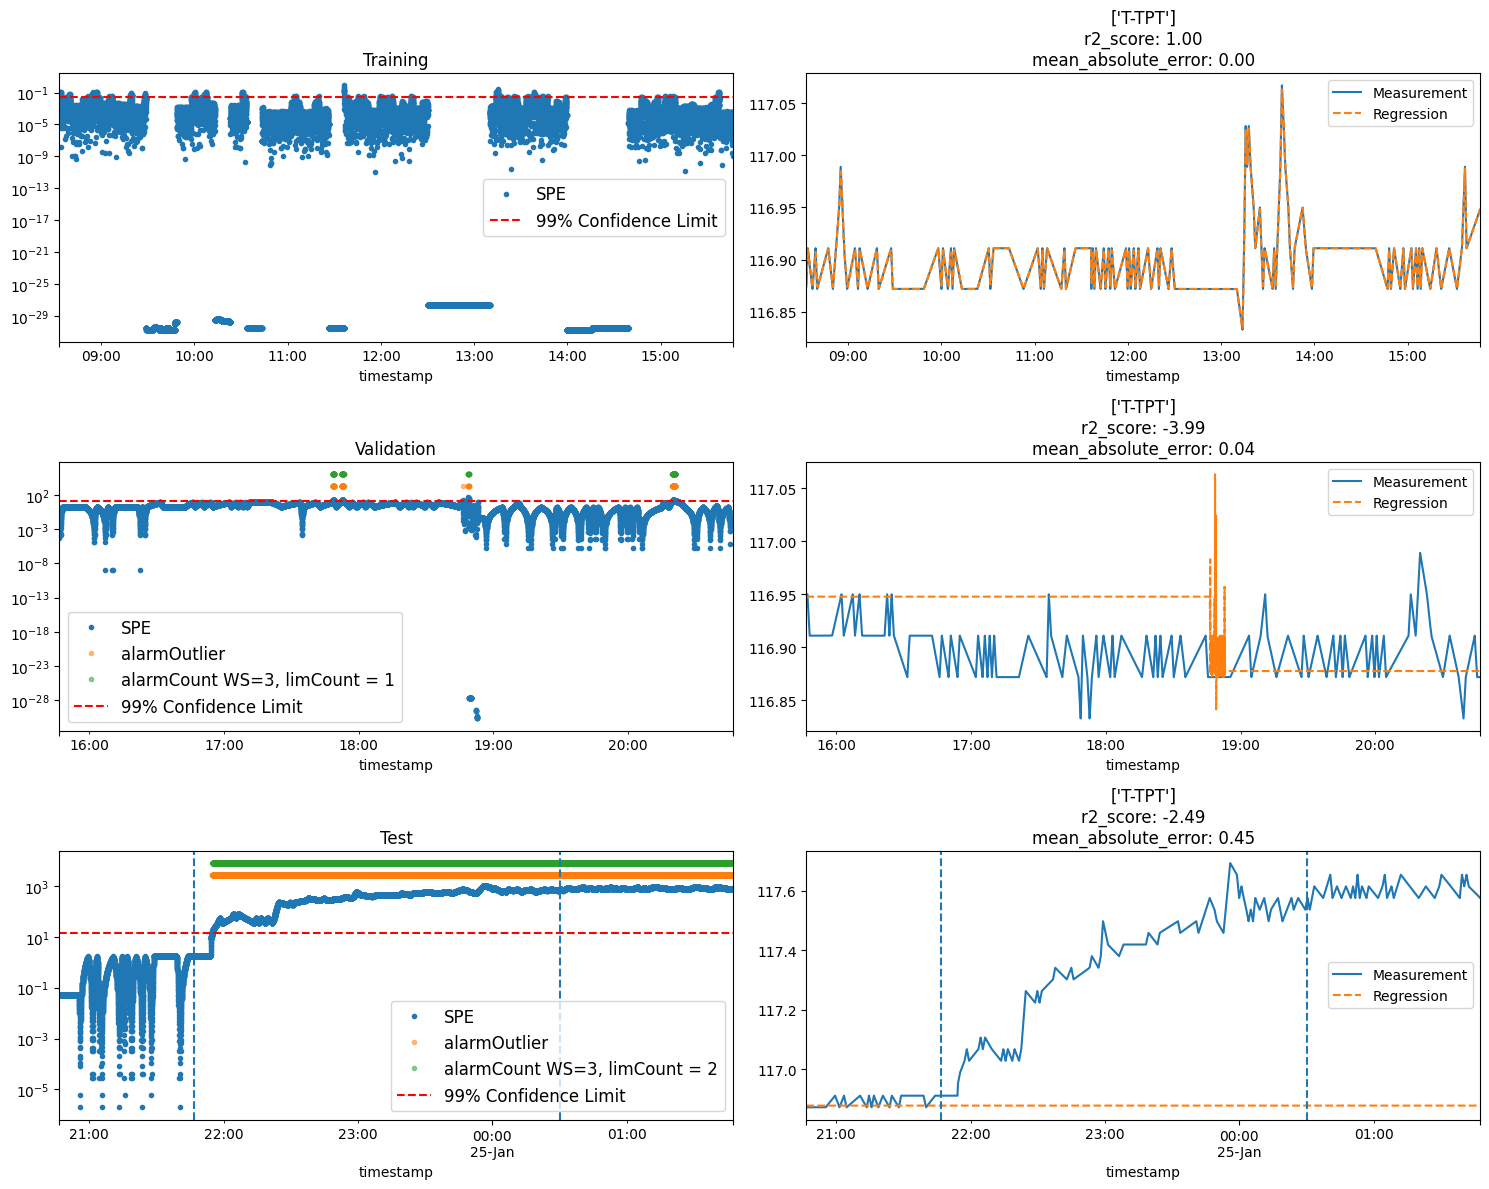

In [105]:
bibmon.complete_analysis(model, X_train['T-JUS-CKP'], X_validation['T-JUS-CKP'], X_test['T-JUS-CKP'], 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = '2014-01-24 21:46:39',
                         fault_end = '2014-01-25 00:30:11')                       

Mas como podemos ver, devido a um fit ruim essa ferramenta também não foi efetiva em reduzir nossos problemas